This page details the NeutralizationBench.py module. 

This is use to simulate reactions between any given number of antigens and antibodies. 
It works on the assumption that a given antibody attaches to only a single site
on the virus.

Assume we have n antigens and m antibodies. We denote antigens by V_i and antibodies 
as Ab_j where i and j are the indices.  Let I denote any selection of indices from 
1,..,m then V_jAb_I denotes the complex formed by virus j and antibodies given by 
the indices I attached. If I=empty then this means just virus j.

We denote the reaction of attachment of antibody i to complex V_jAb_I as:

	[V_jAb_I] + [Ab_i] <=> [V_jAb_I2]

where I2 = I union {i}. In the case I=empty then we just have the usual equation

	[V_j] + [Ab_i] <=> [V_jAb_i]


This reaction is regulated by two constants the forward constant k(j,I,i)
and the backward constant b(j,I,i). k(j,I,i) for instance represents the rate 
of attachment of antibody i to the complex formed by virus j + antibodies I.
As another example k(j,empty,i) would be the rate of attachment of antibody i 
to the virus j (since I=empty means no antibodies are attached to virus).
In such a case, for simplicity we will shows these constants by k(j,i) and drop the empty.
Similarly for b.

If different antibodies dont interfere with each other then k(j,I,i)=k(j,i) 
for any I.

The main inputs to this machinery are therefore the the constants k(j,I,i) and b(j,I,i).
We can make some simplifying assumptions in determination of these constants 
as k(j,I,i) as it stands out could be alot of constants since I is any combination 
of antigen indices in any number.

To start with for simpilicity one can assume b(j,I,i) =1e-3*k(j,I,i) as can be seen 
in the literature (i.e backward rates are rougly 1/1000 of forward rates, see figure 4 in [1]).

We assume forward constants can be represented as:

	k(j,I,i)=k(j,i)*interference(j,I,i)
	
This means that k(j,I,i) equals to original rate of attachment of antigen i to
virus j times an interference term due to antibodies I being bound to virus j.
	
Moreover if I=(i1,...,in) then 

	interference(j,I,i)= interference(j,i1,i)*interference(j,i2,i)*...*interference(j,in,i)
	
This is to say interference due to different antibodies being bound to the virus j
are independent of each other. If all interference constants are 1 then it means that antibodies
dont interefere with each other, if they are all 0 then binding of one antibody
completely prevents the others.	

With these simplifications the constants one needs to determine are as follows:

Given a virus j and antibodies i1,...,in, you have to determine the forward binding
rates k(j,i) and the intereference between each antibody interference(j,k1,k2)
where k1,k2 = i1,...,in.

Note that interference will only have a second order effect on the inactivation 
dynamics. Indeed assume the case of one virus V, and two antibodies A1, A2. If
virus V is already attached to A1, it is neutralized. Therefore also attaching
to A2 does not increase the amount of neutralized viruses. It does however decrease
the amount of antibodies A2 therefore slowing down the reaction V+A2=> VA2 slightly.
So in such a model it is infact the case that the more interference there is 
the more inactivation you get because no antibodies are wasted by binding to a virus
that is already inactivated. Ofcourse whether or not this is biologically reasonable
is another issue. This model works on the assumption that a virus bound to a single
antibody is completely neutralized. If this is not true and that the chance of a virus
being neutralized depends on the number of antibodies bound to it, then this model
would have to be modified to accomodate that. That wont be very diffucult to do though
since it already tracks each variable V_jAb_I seperately. So it boils down to how you
combine them in the end to get the amount of inactivate viruses. One could possibly
introduce an inactivation probability factor r(I) that depends on I so that the
number of in activate viruses is V_jAb_I * r(I) summed over I.


There other inputs required such as the initial concentration of antibody binding sites
and initial concentration of antibodies. A rough estimate for the latter was determined
by using the FRA experiments recently done in Erasmus. One also needs to input which serial
dilutions of sera are used for neutralization and the neutralization time. See the example
code below.

We start by given an example of what kind of equations this package generates. Consider 
a system with 1 antigen and 3 antibodies. We will use the _systemOfEquations function
with print_equations=True. This function is normally called from titrateAntigensAgainstSera
which what the user will be using to get the neutralization and titer curves (you can also
supply print_equations option to this function).

In [5]:
import sys
import numpy as np
from NeutralizationBench import systemOfEquations,titrateAntigensAgainstSera, outputScatterPlot, outputTiterCurvePlot

number_of_antigens=1
number_of_antibodies=3

forward_rates=np.ones((number_of_antigens,number_of_antibodies))
backward_ratios=1e-4*np.ones((number_of_antigens,number_of_antibodies))
interference_matrix=np.zeros((number_of_antigens,number_of_antibodies,number_of_antibodies))    

ode,variables=_systemOfEquations(number_of_antigens,number_of_antibodies,forward_rates,backward_ratios,interference_matrix,print_equations=True)   


System of equations is:

0- d[V0]/dt=-1.0*Ab0*V0 - 1.0*Ab1*V0 - 1.0*Ab2*V0 + 0.0001*V0Ab0 + 0.0001*V0Ab1 + 0.0001*V0Ab2

1- d[Ab0]/dt=-1.0*Ab0*V0 + 0.0001*V0Ab0 + 0.0001*V0Ab01 + 0.0001*V0Ab012 + 0.0001*V0Ab02

2- d[Ab1]/dt=-1.0*Ab1*V0 + 0.0001*V0Ab01 + 0.0001*V0Ab012 + 0.0001*V0Ab1 + 0.0001*V0Ab12

3- d[Ab2]/dt=-1.0*Ab2*V0 + 0.0001*V0Ab012 + 0.0001*V0Ab02 + 0.0001*V0Ab12 + 0.0001*V0Ab2

4- d[V0Ab0]/dt=1.0*Ab0*V0 - 0.0001*V0Ab0 + 0.0001*V0Ab01 + 0.0001*V0Ab02

5- d[V0Ab1]/dt=1.0*Ab1*V0 + 0.0001*V0Ab01 - 0.0001*V0Ab1 + 0.0001*V0Ab12

6- d[V0Ab2]/dt=1.0*Ab2*V0 + 0.0001*V0Ab02 + 0.0001*V0Ab12 - 0.0001*V0Ab2

7- d[V0Ab01]/dt=-0.0002*V0Ab01 + 0.0001*V0Ab012

8- d[V0Ab02]/dt=0.0001*V0Ab012 - 0.0002*V0Ab02

9- d[V0Ab12]/dt=0.0001*V0Ab012 - 0.0002*V0Ab12

10- d[V0Ab012]/dt=-0.0003*V0Ab012



Now we test the percentage law which says that if antibodies in sera is much more
abundant compared to virus, then a change in PFU does not change the titer curves.
We obtain the titer curves for both excess and non-excess sera and plot the titer curves.

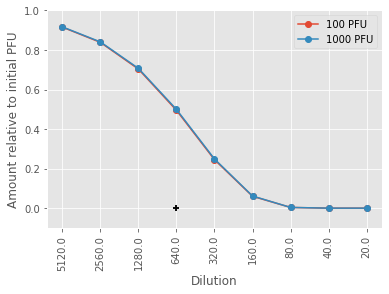

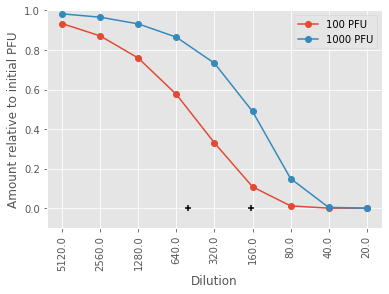

In [27]:
#testing percenage law which says when serum is in excess compared to viruses
#change in PFU does not change titers

number_of_antigens=1
number_of_antibodies=1
M=6e23
vratio=50
nspike=450
ratio=vratio*nspike
total_volume=1e-4


#we first try the case of excess antibodies
#in which we do not observe shift of titer curves with respect to PFU

forward_rates=np.ones((number_of_antigens,number_of_antibodies))*2.5e6/(M)
total_antibody=600*5e9

backward_ratios=1e-3*np.ones((number_of_antigens,number_of_antibodies))
interference_matrix=np.ones((number_of_antigens,number_of_antibodies,number_of_antibodies))

total_PFUs=[100,10000]

ax=None
fig=None
for total_PFU in total_PFUs:  
    init_vals=[total_PFU*ratio/total_volume,total_antibody/total_volume]
    
    
    measurement_time=3600
    dilutions=[1/5120,1/2560,1/1280,1/640,1/320,1/160,1/80,1/40,1/20]
    
    
    y,log_titer,titer,_=titrateAntigensAgainstSera(init_vals,dilutions,number_of_antigens,number_of_antibodies,measurement_time,forward_rates,backward_ratios,interference_matrix)   
    
    ax,fig=outputTiterCurvePlot(y,log_titer,number_of_antigens,dilutions,fig=fig,ax=ax)

    ax.set_ylabel('Amount relative to initial PFU')
    ax.set_xlabel('Dilution')
ax.legend(['100 PFU','1000 PFU'])    
    
#then we try the case of not-excess antibodies
#in which we do not observe shift of titer curves with respect to PFU    
    
forward_rates=np.ones((number_of_antigens,number_of_antibodies))*300e6/(M)
total_antibody=4*5e9

backward_ratios=1e-3*np.ones((number_of_antigens,number_of_antibodies))
interference_matrix=np.ones((number_of_antigens,number_of_antibodies,number_of_antibodies))

total_PFUs=[100,10000]

ax=None
fig=None
for total_PFU in total_PFUs:  
    init_vals=[total_PFU*ratio/total_volume,total_antibody/total_volume]
    
    
    measurement_time=3600
    dilutions=[1/5120,1/2560,1/1280,1/640,1/320,1/160,1/80,1/40,1/20]
    
    
    y,log_titer,titer,_=titrateAntigensAgainstSera(init_vals,dilutions,number_of_antigens,number_of_antibodies,measurement_time,forward_rates,backward_ratios,interference_matrix)   
    
    ax,fig=outputTiterCurvePlot(y,log_titer,number_of_antigens,dilutions,fig=fig,ax=ax)

    ax.set_ylabel('Amount relative to initial PFU')
    ax.set_xlabel('Dilution')    
ax.legend(['100 PFU','1000 PFU'])    


We now test how titers are mixed. Assume we have to antibody solutions with concentrations c1 and c2.

In case one, we first get the titer curves for two antibodies individually and then for sera containing them
mixed in 0.5*c1 and 0.5*c2 concentrations. This corresponds to the case of titrating a virus agains two antibody
solutions first and then making a new solution by taking half of each of the initial solution.

In case two, we again have two antibodoes but we mix them by adding them together (i.e mixed together in 
concentrations c1 and c2). This case corresponds to using an assay that measures HA and NA antibody titers
seperately and then together.
                                                                                  


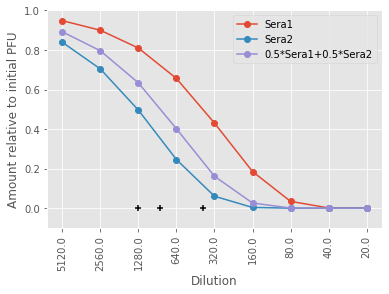

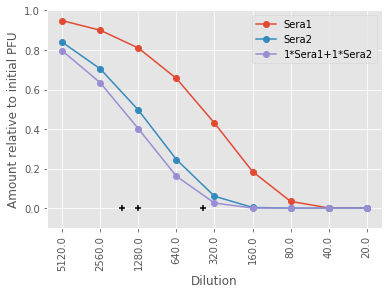

In [28]:
#testing individual sera vs combined sera
import copy

#sera1
number_of_antigens=1
number_of_antibodies=1


forward_rates=np.ones((number_of_antigens,number_of_antibodies))*1.5e6/(M)
total_antibody=600*5e9
backward_ratios=1e-3*np.ones((number_of_antigens,number_of_antibodies))
interference_matrix=np.ones((number_of_antigens,number_of_antibodies,number_of_antibodies))
total_PFU=1000

init_vals=[total_PFU*ratio/total_volume,total_antibody/total_volume]


ax1=None
fig1=None
ax2=None
fig2=None

y,log_titer,titer,_=titrateAntigensAgainstSera(init_vals,dilutions,number_of_antigens,number_of_antibodies,measurement_time,forward_rates,backward_ratios,interference_matrix)   

ax1,fig1=outputTiterCurvePlot(y,log_titer,number_of_antigens,dilutions,fig=fig1,ax=ax1)
ax2,fig2=outputTiterCurvePlot(y,log_titer,number_of_antigens,dilutions,fig=fig2,ax=ax2)

ax1.set_ylabel('Amount relative to initial PFU')
ax1.set_xlabel('Dilution')
ax2.set_ylabel('Amount relative to initial PFU')
ax2.set_xlabel('Dilution')

#sera 2
forward_rates=np.ones((number_of_antigens,number_of_antibodies))*5e6/(M)

y,log_titer,titer,_=titrateAntigensAgainstSera(init_vals,dilutions,number_of_antigens,number_of_antibodies,measurement_time,forward_rates,backward_ratios,interference_matrix)   

ax1,fig1=outputTiterCurvePlot(y,log_titer,number_of_antigens,dilutions,fig=fig1,ax=ax1)
ax2,fig2=outputTiterCurvePlot(y,log_titer,number_of_antigens,dilutions,fig=fig2,ax=ax2)
ax1.set_ylabel('Amount relative to initial PFU')
ax1.set_xlabel('Dilution')


#combined 0.5sera1 + 0.5sera2
number_of_antigens=1
number_of_antibodies=2


forward_rates=np.ones((number_of_antigens,number_of_antibodies))*1.5e6/(M)
forward_rates[0,1]=5e6/M
total_antibody=600*5e9
backward_ratios=1e-3*np.ones((number_of_antigens,number_of_antibodies))
interference_matrix=np.ones((number_of_antigens,number_of_antibodies,number_of_antibodies))
total_PFU=1000

init_vals=[total_PFU*ratio/total_volume,0.5*total_antibody/total_volume,0.5*total_antibody/total_volume]


y,log_titer,titer,_=titrateAntigensAgainstSera(init_vals,dilutions,number_of_antigens,number_of_antibodies,measurement_time,forward_rates,backward_ratios,interference_matrix)   

ax1,fig1=outputTiterCurvePlot(y,log_titer,number_of_antigens,dilutions,fig=fig1,ax=ax1)

ax1.legend(['Sera1','Sera2','0.5*Sera1+0.5*Sera2'])

#combined sera1 + sera2

init_vals=[total_PFU*ratio/total_volume,1*total_antibody/total_volume,1*total_antibody/total_volume]

y,log_titer,titer,_=titrateAntigensAgainstSera(init_vals,dilutions,number_of_antigens,number_of_antibodies,measurement_time,forward_rates,backward_ratios,interference_matrix)   

ax2,fig2=outputTiterCurvePlot(y,log_titer,number_of_antigens,dilutions,fig=fig2,ax=ax2)
ax2.legend(['Sera1','Sera2','1*Sera1+1*Sera2'])


We see that in the first case, the mixed titer is somewhere between the first two (although it does not look 
exactly like arithmetic mean). In the second case as expected, mixed titer is higher.